<a href="https://colab.research.google.com/github/Abdul-Wahab-318/News-Topic-Classification/blob/main/NLP_Project_Naive_Bayes_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessary Libraries**

In [53]:
# !pip install wordcloud

!pip install gradio

In [54]:
import pandas as pd
import numpy as np
import re
import string
import spacy
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report , confusion_matrix , precision_score , recall_score , f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# **Import data and understand it**

In [56]:
df_train = pd.read_csv("./train.csv")
df_test = pd.read_csv("./test.csv")
df_train

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


Class Index : 1 - World , 2 - Sports , 3 - Business , 4 - Tech/Sci

In [57]:
print('Training data : ' , df_train.shape)
print('Testing data : ' , df_test.shape)

Training data :  (120000, 3)
Testing data :  (7600, 3)


In [58]:
df_train.rename(columns={'Class Index' : 'class' , 'Title' : 'title' , 'Description' : 'description'} , inplace=True)
df_test.rename(columns={'Class Index' : 'class' , 'Title' : 'title' , 'Description' : 'description'} , inplace=True)

In [59]:
news_train = df_train.copy()
world_news = df_train[df_train['class'] == 1]
sports_news = df_train[df_train['class'] == 2]
business_news = df_train[df_train['class'] == 3]
tech_news = df_train[df_train['class'] == 4]

**Dataset is balanced**

In [60]:
news_train['class'].value_counts()

,count
class,
3,30000
4,30000
2,30000
1,30000


# **Text Preprocessing**

In [61]:
news_train['content'] = news_train['title'] + " " + news_train['description']
news_train.drop(columns=['title' , 'description'] , inplace=True)

x_train = news_train['content']
y_train = news_train['class']

In [62]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def remove_html_tag(text):
    html = re.compile('<.*?')
    cleaned_text = html.sub('', text)
    return cleaned_text

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_non_alphabets(text):
  text = re.sub(r'#39;s' , repl=" " , string=text)
  return re.sub(r'[^a-zA-Z$]' , repl=" " , string=text)

def tokenize(text):
  return word_tokenize(text.lower())

def remove_stop_words(tokens):
  stop_words = set(stopwords.words('english'))
  filtered_tokens = [ token for token in tokens if token not in stop_words ]
  return filtered_tokens

def remove_extra_words(tokens):
  extra_words={'sunday','monday','tuesday','wednesday','thursday','friday','saturday','reuter','reuters','week','new','say','said','saying','ap','gt','lt','st','quot','ie','com','www','http'}
  filtered_tokens = [ token for token in tokens if token not in extra_words ]
  return filtered_tokens

def lemmatize(tokens):
  stemmed_tokens = [ lemmatizer.lemmatize(token) for token in tokens ]
  return stemmed_tokens

def preprocess_text(text):
  cleaned_text = remove_html_tag(text)
  cleaned_text = remove_url(text)
  cleaned_text = remove_non_alphabets(text)
  tokens = tokenize(cleaned_text)
  tokens = remove_stop_words(tokens)
  tokens = lemmatize(tokens)
  tokens = remove_extra_words(tokens)

  return ' '.join(tokens)


In [63]:
x_train_cleaned = x_train.map(lambda content : preprocess_text(content))

# Exploratory Data Analysis

In [64]:
corpus = x_train_cleaned.to_numpy()

In [65]:
def generate_wordcloud(corpus):

  corpus = " ".join(corpus)
  wordcloud = WordCloud().generate(corpus)

  # Display the generated image using matplotlib.
  # Create a new word cloud with adjusted font size.
  wordcloud = WordCloud(max_font_size=40).generate(corpus)

  # Create a new figure and display the adjusted word cloud.

  plt.figure()

  plt.imshow(wordcloud, interpolation="bilinear")

  plt.axis("off")

  # Show the word cloud

  plt.show()


# **Word Clouds**

In [66]:
generate_wordcloud(corpus)

In [67]:
train_cleaned = pd.DataFrame({'class' : y_train , 'content' : x_train_cleaned})
world_news_corpus = train_cleaned[train_cleaned['class'] == 1]['content'].values
sports_news_corpus = train_cleaned[train_cleaned['class'] == 2]['content'].values
business_news_corpus = train_cleaned[train_cleaned['class'] == 3]['content'].values
tech_news_corpus = train_cleaned[train_cleaned['class'] == 4]['content'].values

**World News Corpus**

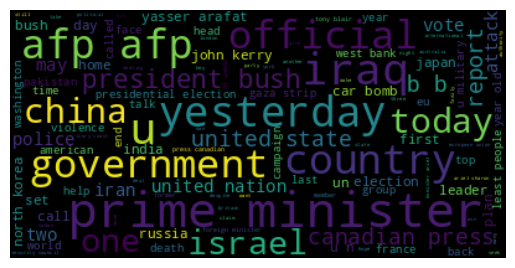

In [68]:
generate_wordcloud(world_news_corpus)

**Sports News Corpus**

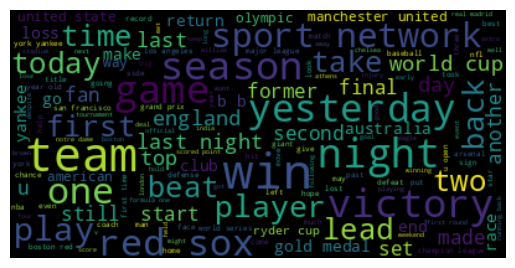

In [69]:
generate_wordcloud(sports_news_corpus)

**Business News Corpus**

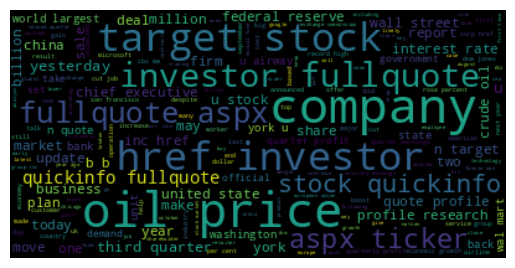

In [70]:
generate_wordcloud(business_news_corpus)

**Tech News Corpus**

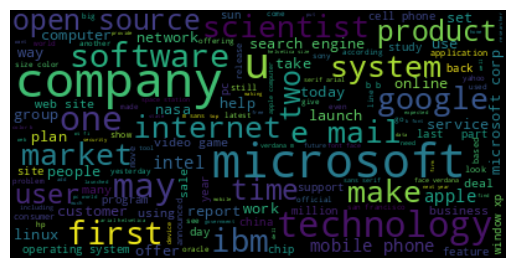

In [71]:
generate_wordcloud(tech_news_corpus)

In [72]:
tfidf = TfidfVectorizer(stop_words='english' , max_features=900 , ngram_range=(1,3) , min_df=8)
X_train_transformed = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names_out()
X_train_transformed = pd.DataFrame(X_train_transformed , columns=feature_names)

In [73]:
X_train_transformed.head()

,access,according,accused,acquisition,action,ad,add,administration,afghan,afghanistan,...,yard,yasser,yasser arafat,year,year ago,year old,yesterday,york,young,yukos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Model training and hyperparameter tuning**

In [74]:
# from sklearn.model_selection import cross_val_score
naive_bayes = MultinomialNB(fit_prior=False)
# cv = cross_val_score(naive_bayes , X_train_transformed , y_train , cv=4 , scoring='f1_weighted')
# print('--- Average F1-Score for MNB model: {} ---'.format(round(cv.mean(), 3)))

In [75]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    #'alpha' : [0.6 , 0.5 , 0.3 , 0.2 , 0.1 , 0.01 , 0.001 , 0.0001 ]
    'alpha' : [ 0.01 ]
}

grid_search = GridSearchCV(naive_bayes, param_grid = param_grid, cv=3, scoring="f1_weighted", return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_transformed.values , y_train.values)
model = grid_search.best_estimator_

In [76]:
print("Best Score : " , grid_search.best_params_ , " : " , grid_search.best_score_ )

Best Score :  {'alpha': 0.01}  :  0.8507011880812739


In [77]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.212216,0.43643,0.152471,0.031789,0.01,{'alpha': 0.01},0.84769,0.855199,0.849215,0.850701,0.003241,1,0.861349,0.857118,0.857123,0.85853,0.001993


# Evaluate Test Set

In [78]:
X_test = pd.DataFrame(df_test['title'] + " : " + df_test['description'] , columns=['content'])
y_test = df_test['class']

In [79]:
X_test_cleaned = X_test['content'].apply(lambda content : preprocess_text(content)).values
X_test_transformed = tfidf.transform(X_test_cleaned)
y_test = df_test['class'].values

In [80]:
y_pred = model.predict(X_test_transformed)
y_pred

array([3, 4, 4, ..., 2, 3, 4])

In [81]:
test_precision = precision_score(y_pred , y_test , average="weighted")
test_recall = recall_score(y_pred , y_test , average="weighted")
test_f1 = f1_score(y_pred , y_test , average="weighted")

print("Precision : " , test_precision)
print("Recall : " , test_recall)
print("F1 : " , test_f1)

Precision :  0.8500102493074791
Recall :  0.8482894736842105
F1 :  0.8489510185115013


In [82]:
def report_confusion_matrix(y_test, y_pred):

    """
    Plot a confusion matrix heatmap

    Parameters:

        y_test (array-like): Real labels.

        y_pred (array-like): Predicted labels.


    Returns:

        None

    """

    # Define class names

    class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

    # Print classification report

    print(classification_report(y_test, y_pred, target_names=class_names))

    # Calculate confusion matrix

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot heatmap

    plt.figure(figsize=(5, 4))

    sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted Labels')

    plt.ylabel('Real Labels')

    plt.title('Confusion Matrix')

    plt.show()

# Confusion Matrix

              precision    recall  f1-score   support

       World       0.86      0.87      0.86      1900
      Sports       0.90      0.93      0.92      1900
    Business       0.82      0.78      0.80      1900
    Sci/Tech       0.82      0.81      0.81      1900

    accuracy                           0.85      7600
   macro avg       0.85      0.85      0.85      7600
weighted avg       0.85      0.85      0.85      7600



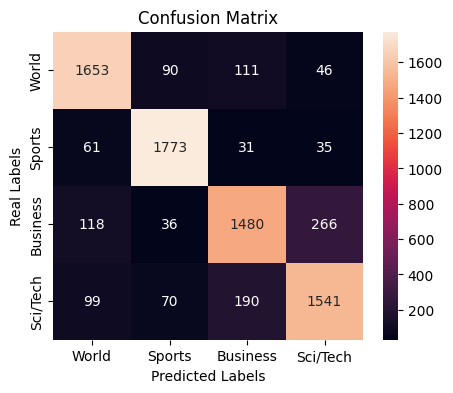

In [83]:
# Display confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

report_confusion_matrix(y_test,y_pred)

# Error Analysis

In [84]:
for i , (title , y , y_hat) in enumerate(zip(X_test['content'].values , y_test , y_pred)):
  real_labels = ['World' , 'Sports' , 'Business' , 'Tech']

  if np.abs(y - y_hat) > 0:

      print(f'\nReal label: {real_labels[y-1]}\tVS\tPredicted label: {real_labels[y_hat-1]}\n')

      print(f'THE REVIEW IS: {title}\n')

      print(f'THE PROCESSED REVIEW IS:{X_test_cleaned[i]}\n\n')


Streaming output truncated to the last 5000 lines.

Real label: World	VS	Predicted label: Sports

THE REVIEW IS: Canada defends submarine fleet : Canada has defended its decision to buy second-hand submarines after a crewman died from injuries sustained on one of the vessels that had broken down.

THE PROCESSED REVIEW IS:canada defends submarine fleet canada defended decision buy second hand submarine crewman died injury sustained one vessel broken



Real label: Business	VS	Predicted label: World

THE REVIEW IS: Statement by Airbus on the US Government for formal consultations &lt;b&gt;...&lt;/b&gt; : Airbus has fully supported all recent actions by the European Commission to engage with the US government in serious discussions on comprehensive new disciplines on government support.

THE PROCESSED REVIEW IS:statement airbus u government formal consultation b b airbus fully supported recent action european commission engage u government serious discussion comprehensive discipline gover

***Upon closer inspection, the misclassified instances are those that could potentially belong to both classes. For example, many articles have content that is both business and tech related. In this case, the model struggles to decide whether it should classify the article as business or tech related***

In [85]:
pipeline = Pipeline([
    ('tfidf' ,tfidf),
    ('NB' , model)
])

def predict(text):
  cleaned_text = preprocess_text(text)
  pred_label = pipeline.predict([cleaned_text])

  text_labels = ['World' , 'Sports' , 'Business' , 'Tech']
  ans = text_labels[pred_label[0]-1]
  return ans


In [86]:
import gradio as gr
demo = gr.Interface(fn=predict, inputs="textbox", outputs="textbox")

In [87]:
#demo.launch(share=True , debug=True)